# Get started with MultiVae

In this tutorial we detail a simple example on how to train and evaluate a model with MultiVae.

## Load a toy dataset

As a toy example here (and to allow fast training), we load the MnistLabels dataset from the library.
The first modality is the image and the second "modality" is the label. 

In [9]:
from multivae.data.datasets.mnist_labels import MnistLabels

DATA_PATH = './data' # Set the path where to download the data
dataset = MnistLabels(DATA_PATH, 'test',download=True) # Set download to True

For all datasets in MultiVae, the ```__getitem__``` function returns a ```~pythae.data.datasets.DatasetOutput``` class which contains a field `data` with all modalities (here 'images' and 'labels')

The modalities in that dataset are named ['images', 'labels']
The text attribute for this image is tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


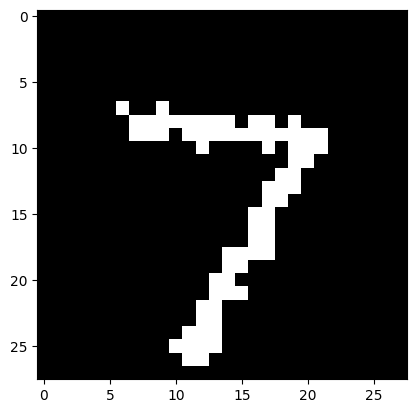

In [10]:
# Visualize one sample
import matplotlib.pyplot as plt
sample = dataset[0]

# A sample contains a field 'data' with the data for both modalities (here images and labels) and eventual additional fields (labels, masks..)
print(f'The modalities in that dataset are named {list(sample.data.keys())}')

plt.imshow(sample.data['images'][0], cmap='gray')
print(f'The text attribute for this image is {sample.data["labels"]}')


## Create a model 

Now that we have our dataset, we can import the model of our choice. To have a list of available models, you can look at the documentation [here](https://multivae.readthedocs.io/en/latest/models/multivae.models.html). In the documentation, you also have a description of each model's hyperparameters. 

In [12]:
# Import the model of your choice
from multivae.models import MVTCAE, MVTCAEConfig

In [13]:
# Define the model configuration

model_config = MVTCAEConfig(
    n_modalities=2,
    latent_dim=20,
    input_dims= {'images' : (1,28,28), 'labels' : (1,10)},
    decoders_dist= {'images' : 'normal', 'labels' : 'categorical'}, # Distributions to use for the decoders. It defines the reconstruction loss.
    
    alpha=2./3.,
    beta=2.5,
    
    uses_likelihood_rescaling=True,
    rescale_factors=dict(images=1, labels=50)
)

Here we will use the default Multi-Layer-Perceptron architectures. Of course for more complex use-cases, you might want to provide your own architectures through the encoders/ decoders argument of the model. We will see how to do that in the next section of this notebook. 

In [16]:
# Initialize the model

# If no encoders/ decoders architectures are specified, default MLPs are used
model = MVTCAE(model_config = model_config)

In [17]:
# check that everything works
model(dataset[:10])

ModelOutput([('loss', tensor(628.3367, grad_fn=<DivBackward0>)),
             ('loss_sum', tensor(6283.3667, grad_fn=<AddBackward0>)),
             ('metrics',
              {'joint_divergence': tensor(19.6089, grad_fn=<MulBackward0>),
               'images': tensor(8192.8711, grad_fn=<SumBackward0>),
               'labels': tensor(1159.0118, grad_fn=<SumBackward0>),
               'kld_images': tensor(19.7253, grad_fn=<SumBackward0>),
               'kld_labels': tensor(19.1992, grad_fn=<SumBackward0>)})])

The forward function of the model computes the mean loss on the batch as well as some metrics. 


## Using custom architectures

You can use custom architectures instead of the default ones. Your architectures simply need to inherit from the [BaseEncoder](https://pythae.readthedocs.io/en/latest/models/nn/pythae_base_nn.html#pythae.models.nn.BaseEncoder) class and the [BaseDecoder](https://pythae.readthedocs.io/en/latest/models/nn/pythae_base_nn.html#pythae.models.nn.BaseDecoder) class. 
Below we define two simple convolutional architecture that can be used to encode the MNIST images. 

In [18]:
from multivae.models.base import BaseEncoder, BaseDecoder, ModelOutput
import torch

# The custom encoder must be an instance of the BaseEncoder class
class ImageEncoder(BaseEncoder):
    
    "A simple custom convolutional architecture to use on MNIST images."
    
    def __init__(self):
        super().__init__()
        self.latent_dim = 20 
        
        self.conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=0),
            torch.nn.ReLU(True),
            torch.nn.Flatten(start_dim=1)
        )
        

        self.embedding_layer = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 32, self.latent_dim)
        )
        self.covariance_layer = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 32, self.latent_dim)
        )
        
    def forward(self, x):
        h = self.conv_net(x)
        
        #### The output of the variational encoder must be a ModelOutput instance 
        #### with an embedding field and log_covariance field
        
        return ModelOutput(
            embedding = self.embedding_layer(h),
            log_covariance = self.covariance_layer(h)
        )
    
# The custom decoder must be an instance of the BaseDecoder class
class ImageDecoder(BaseDecoder):
    
    def __init__(self):
        
        super().__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(20, 3*3*32),
            torch.nn.ReLU(True),
            torch.nn.Unflatten(dim=1,
            unflattened_size=(32, 3, 3))
        )


        self.conv_net = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1),
            
        )
        
    def forward(self, x):
        h = self.linear(x)
        h = self.conv_net(h)
        x = torch.sigmoid(h)
        
        #### The output must be a ModelOutput instance with a 'reconstruction' field
        return ModelOutput(reconstruction = x)
    
    

Here we instantiate a model with custom architectures provided. Note that for the labels, we use simple MLPs from the MultiVae library.

In [20]:
from multivae.models.nn.default_architectures import Encoder_VAE_MLP, Decoder_AE_MLP, BaseAEConfig

label_encoder = Encoder_VAE_MLP(BaseAEConfig(input_dim = (10,), latent_dim=20))
label_decoder = Decoder_AE_MLP(BaseAEConfig(input_dim=(10,), latent_dim=20))

model_custom = MVTCAE(model_config=model_config,
               encoders = dict(images = ImageEncoder(), labels=label_encoder),
               decoders=dict(images = ImageDecoder(), labels=label_decoder))

In [21]:
# check that everything works
model_custom(dataset[:10])

ModelOutput([('loss', tensor(1307.8213, grad_fn=<DivBackward0>)),
             ('loss_sum', tensor(13078.2129, grad_fn=<AddBackward0>)),
             ('metrics',
              {'joint_divergence': tensor(19.3067, grad_fn=<MulBackward0>),
               'images': tensor(8025.1890, grad_fn=<SumBackward0>),
               'labels': tensor(11519.3818, grad_fn=<SumBackward0>),
               'kld_images': tensor(19.3244, grad_fn=<SumBackward0>),
               'kld_labels': tensor(19.5676, grad_fn=<SumBackward0>)})])

## Training

In MultiVae, training can be easily performed using the MultiVae's trainers. Below we define a simple trainer and use it for training our model. 
Many arguments can be passed on to `BaseTrainerConfig`: check out the [documentation](https://multivae.readthedocs.io/en/latest/trainers/base.html#multivae.trainers.BaseTrainer) for more details. 

In [24]:
from multivae.trainers import BaseTrainer, BaseTrainerConfig

#Define the training configuration
trainer_config = BaseTrainerConfig(
    num_epochs=10,
    learning_rate=1e-2, 
    optimizer_cls='Adam',
    output_dir='dummy_output_dir'
    
)

# Define the trainer
trainer = BaseTrainer(
    model=model,
    training_config=trainer_config,
    train_dataset=dataset
    )



! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.01
Created dummy_output_dir/MVTCAE_training_2025-02-24_10-22-27. 
Training config, checkpoints and final model will be saved here.



In [25]:
# Now we train:

trainer.train() 

Training params:
 - max_epochs: 10
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Training of epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 98.24batch/s] 
--------------------------------------------------------------------------
Train loss: 559.0608
--------------------------------------------------------------------------
Training of epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 98.42batch/s]
--------------------------------------------------------------------------
Train loss: 558.526
--------------------------------------------------------------------------
Training of epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 100.33batch/s]
-------

After training, we can reload the best model saved by the trainer. 

In [28]:
from multivae.models.auto_model import AutoModel

best_model = AutoModel.load_from_folder(f'{trainer.training_dir}/final_model') # Copy the path to final model.

Now we can call the `predict` function of the model to generate some samples, conditioning on a specific label. 

Images generated by conditioning on label =  tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


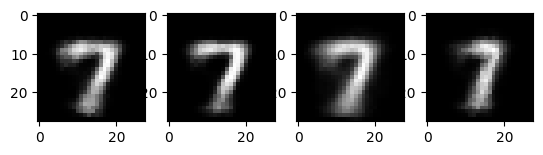

In [34]:
best_model = best_model.eval()

# images from label : show a few samples 
predictions = best_model.predict(
    inputs=dataset[0],
    cond_mod='labels', # The labels will be used as the conditioning modality
    N = 4, # We generate 4 samples
)

# Plot
print("Images generated by conditioning on label = ", dataset[0].data['labels'])
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(predictions['images'][i][0][0].detach(), cmap='gray')

## Computing metrics

To further evaluate your model, you can compute some metrics like likelihoods, coherence, clustering metrics, reconstruction metrics, or additional visualization. You can check out the [documentation](https://multivae.readthedocs.io/en/latest/metrics/multivae.metrics.html) for more details.

In [36]:
from multivae.metrics.likelihoods import LikelihoodsEvaluator, LikelihoodsEvaluatorConfig

ll_config = LikelihoodsEvaluatorConfig(
    batch_size=128,
    num_samples=100)

ll = LikelihoodsEvaluator(
    best_model,dataset,eval_config=ll_config
)

ll.eval() #might take some time

100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
Joint likelihood : tensor(752.7989)


ModelOutput([('joint_likelihood', tensor(752.7989))])